In [7]:
# Load libraries
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load Dataset

In [11]:
# Define image and label array
images, labels = [], []

In [12]:
# Iter each folder
basedir = "dataset/"
for folder in tqdm(os.listdir(basedir)):

    # Iter each file
    folder_path = os.path.join(basedir, folder)
    for filename in os.listdir(folder_path):
        
        # Read image as RGB format + Resize (256, 256) and push into "images" & "labels" array
        filename = os.path.join(folder_path, filename)
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        
        images.append(img)
        labels.append(folder)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.51s/it]


In [13]:
# Transform list into np.array
images = np.array(images)
labels = np.array(labels)

In [14]:
# Check dimension
images.shape, labels.shape

((1201, 256, 256, 3), (1201,))

# Exploratory Data Analysis

In [15]:
# Load libraries 
import matplotlib.pyplot as plt

# Set matplotlib styling
plt.style.use("ggplot")

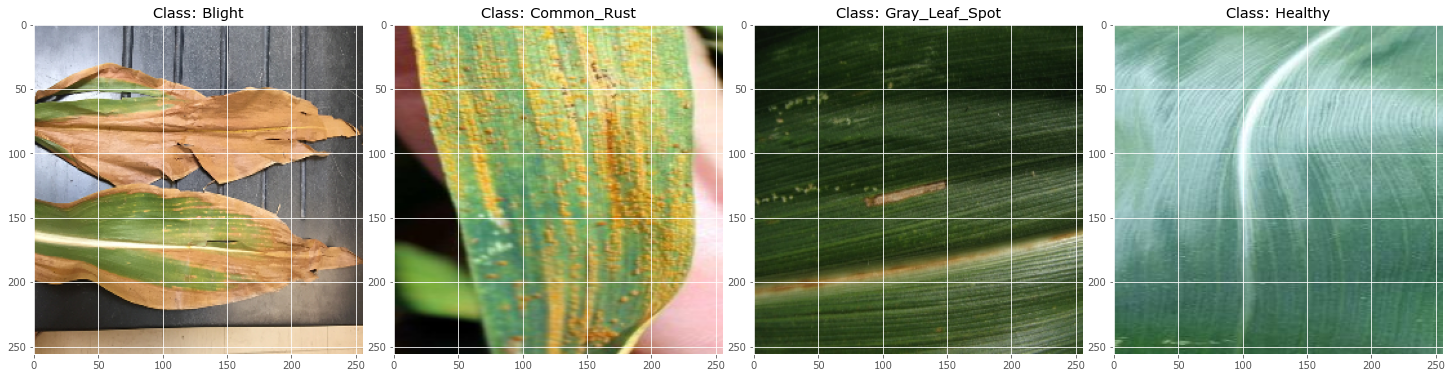

In [21]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    ax[n_col].imshow(image)
    ax[n_col].set_title(f"Class: {cls}")
    count += 1
        
plt.tight_layout(pad=0);

In [25]:
# Label Distribution
data = pd.DataFrame({"Labels" : labels})
pd.DataFrame(data['Labels'].value_counts())

# NOTE: Based on this label distribution we can overview if dataset is "imbalance" with least ratio significance

,Labels
Blight,301
Common_Rust,300
Gray_Leaf_Spot,300
Healthy,300


# Image Segmentation

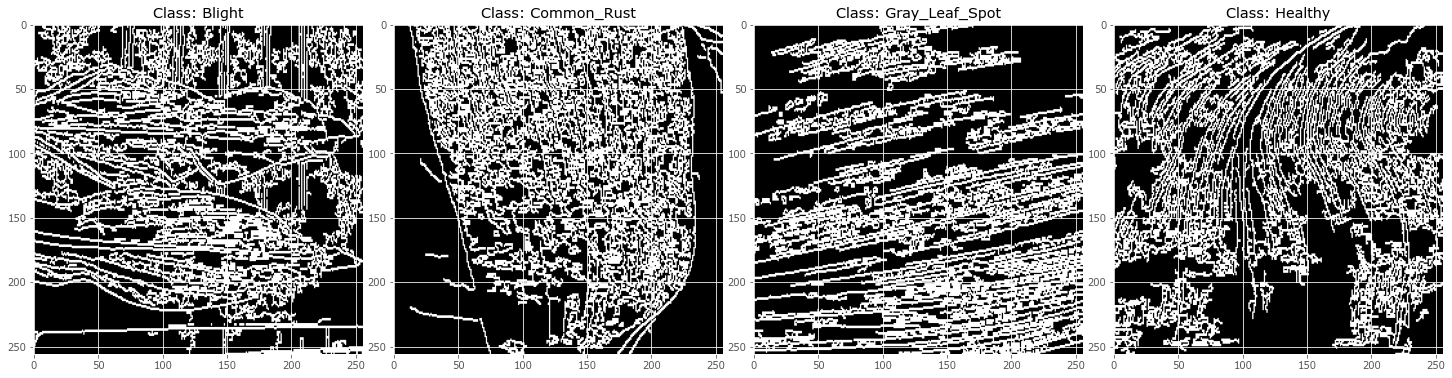

In [35]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image_segmented = cv.Canny(image, 10, 150)
    image_segmented = cv.dilate(image_segmented, (3, 3), 5)
    ax[n_col].imshow(image_segmented, cmap = "gray")
    ax[n_col].set_title(f"Class: {cls}")
    count += 1
        
plt.tight_layout(pad=0);

# Image Augmentation

![](https://www.mdpi.com/information/information-14-00054/article_deploy/html/images/information-14-00054-g001.png)

In [41]:
# Load libraries
import random

In [42]:
# define function to pick random "True" value
def pick_random_true(list_boolean):
    true_indices = [i for i, value in enumerate(list_boolean) if value]
    random_index = random.choice(true_indices)
    return random_index

In [51]:
# Add 1 image on each cls if total labels is not equal to 301
images_oversampling = []
labels_oversampling = []

threshold = 301
for label in np.unique(labels):
    indices = labels == label
    n_label = labels[indices].shape[0]
    images_oversampling.extend(images[indices])
    labels_oversampling.extend(labels[indices])
    while n_label != threshold:
        random_index = pick_random_true(list(indices))
        images_oversampling.append(images[random_index])
        labels_oversampling.append(labels[random_index])
        n_label += 1

In [52]:
# Label Distribution - after oversampling
data = pd.DataFrame({"Labels" : labels_oversampling})
pd.DataFrame(data['Labels'].value_counts())

,Labels
Blight,301
Common_Rust,301
Gray_Leaf_Spot,301
Healthy,301


# Feature Extraction

![](https://cvexplained.files.wordpress.com/2020/07/image-45.png?w=847)

[Hu Moments Concept](https://cvexplained.wordpress.com/2020/07/21/10-4-hu-moments/)

In [57]:
# define function to generate Hu moment feature based on grayscale image
def fd_hu_moments(image):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    return feature

In [64]:
# feature hu moments
# Iter each image in oversampling mode and apply hu-moments
feature_hu_moments = list(map(lambda x: fd_hu_moments(x), images_oversampling))
feature_hu_moments = np.array(feature_hu_moments)

In [68]:
# Assign as label
features = pd.DataFrame.from_records(feature_hu_moments)
features.columns = [f"HU_{i}" for i in range(7)]

In [71]:
# Concat with label dataset
final_data = pd.concat([features, data], axis = 1)

# Overview final dataset
final_data.head()

,HU_0,HU_1,HU_2,HU_3,HU_4,HU_5,HU_6,Labels
0,0.001143,2.989491e-08,7.628876e-12,2.537469e-13,2.663019e-25,4.163297e-17,2.317863e-25,Blight
1,0.001388,5.058895e-08,1.478029e-11,6.756152e-13,-6.471623e-25,1.020381e-16,2.034515e-24,Blight
2,0.001499,2.386233e-09,1.063546e-11,9.143453e-13,-3.579102e-26,-2.801119e-17,2.851080e-24,Blight
3,0.001315,2.918362e-08,7.924330e-11,1.497094e-12,-1.679072e-24,-2.455858e-16,-1.621960e-23,Blight
4,0.001228,5.217871e-08,5.000429e-12,9.705752e-13,2.425799e-25,-2.194211e-16,2.124390e-24,Blight


# Data Modeling

In [72]:
# Load libraries
from sklearn.model_selection import train_test_split

In [73]:
# Split dataset into train-test with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(final_data.drop("Labels", axis = 1), final_data['Labels'], test_size = 0.2)

# Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((963, 7), (241, 7), (963,), (241,))

## SVM Modeling

In [86]:
# Load libraries
import seaborn as sn
from sklearn.svm import SVC
from warnings import filterwarnings
from sklearn.metrics import classification_report, confusion_matrix

filterwarnings("ignore")

In [93]:
# define function to visualize confusion matrix
def plot_custom_cm(true_labels, pred_labels, classes = list(np.unique(labels))):
    array = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(array, columns = classes, index = classes)
    plt.figure(figsize = (20, 10))
    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot = True, annot_kws={"size": 16})

In [88]:
# Define classes
classes = list(np.unique(labels))

In [89]:
# Define algorithm
model_svm_baseline = SVC()
model_svm_baseline.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [90]:
# Training Algorithm
model_svm_baseline.fit(X_train, y_train)

SVC()

In [95]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_train)
print(classification_report(y_train, pred, target_names = classes))

                precision    recall  f1-score   support

        Blight       1.00      1.00      1.00       245
   Common_Rust       1.00      1.00      1.00       237
Gray_Leaf_Spot       1.00      1.00      1.00       234
       Healthy       1.00      1.00      1.00       247

      accuracy                           1.00       963
     macro avg       1.00      1.00      1.00       963
  weighted avg       1.00      1.00      1.00       963



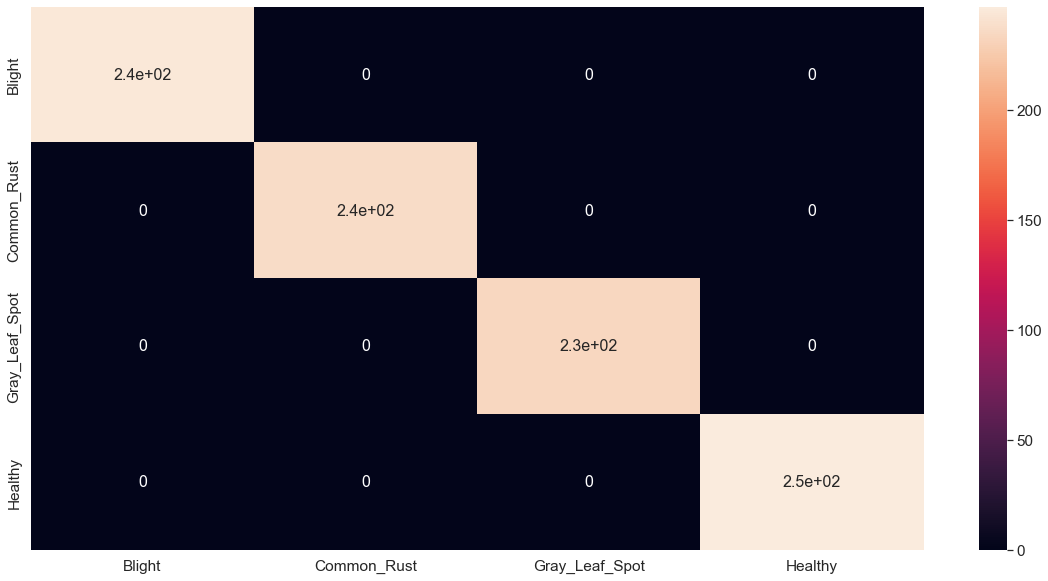

In [96]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_train, pred)

In [100]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_test)
print(classification_report(y_test, pred, target_names = classes))

                precision    recall  f1-score   support

        Blight       0.90      1.00      0.95        56
   Common_Rust       0.98      0.95      0.97        64
Gray_Leaf_Spot       1.00      0.99      0.99        67
       Healthy       1.00      0.94      0.97        54

      accuracy                           0.97       241
     macro avg       0.97      0.97      0.97       241
  weighted avg       0.97      0.97      0.97       241



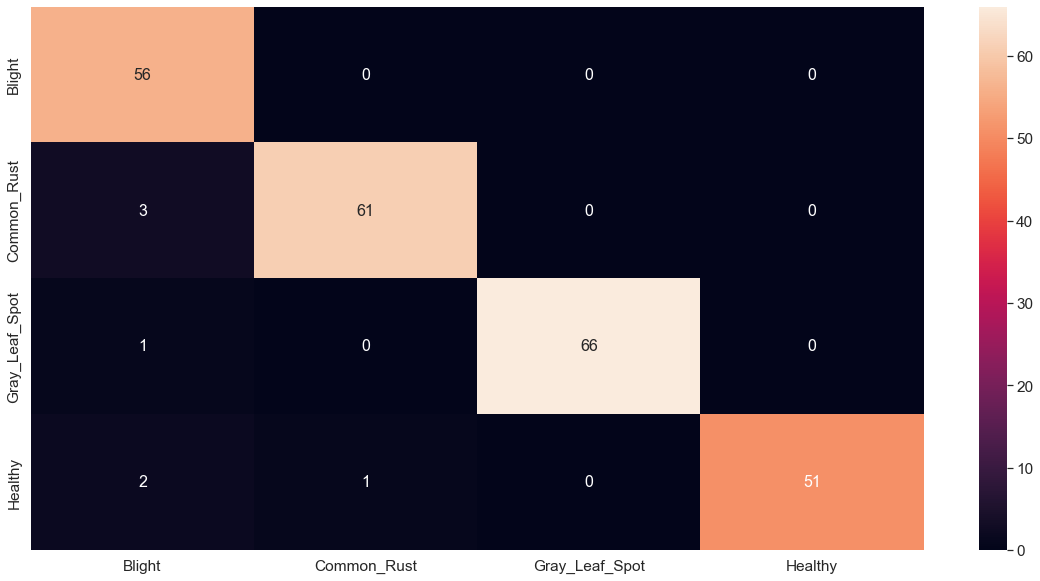

In [101]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_test, pred)

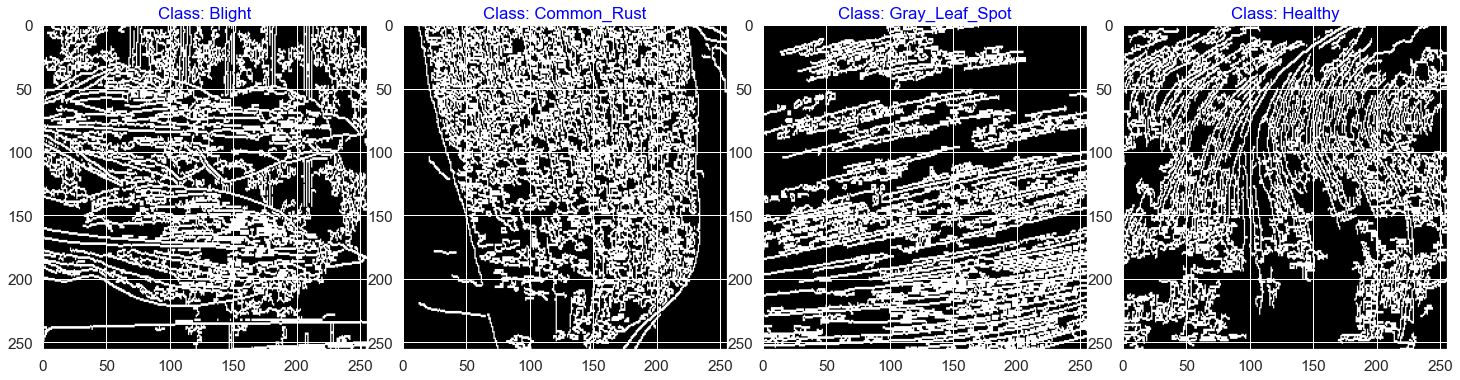

In [103]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image_segmented = cv.Canny(image, 10, 150)
    image_segmented = cv.dilate(image_segmented, (3, 3), 5)
    ax[n_col].imshow(image_segmented, cmap = "gray")
    ax[n_col].set_title(f"Class: {cls}")
    ax[n_col].title.set_color("blue" if preds_label == cls else "red")
    count += 1
        
plt.tight_layout(pad=0);
# NOTE: Blue color indicate "correct" prediction